# Integration with bulk RNA-seq data

A current limitation of single-cell datasets is the high cost, low sample size and often the lack of associated clinical information. On the other hand bulk RNA-seq experiments are comparatively cheap, and vast amounts of experimental data has accumulated in public repositories, including large-scale datasets with thousands of samples. This motivates integrating bulk RNA-seq data with cell-type information from single-cell RNA-seq datasets.

:::{note}
*Deconvolution methods* allow to infer cell-type proportions from bulk RNA-seq datasets based on reference signatures. Methods such as CIBERSORTx {cite}`newmanDeterminingCellType2019`, DWLS {cite}`tsoucasAccurateEstimationCelltype2019` or MuSiC {cite}`wangBulkTissueCell2019` can build such reference signatures based on single-cell RNA-seq datasets. The derived cell-type fractions can be tested for associations with clinical data. In {cite:t}`pournaraPowerAnalysisCelltype2023a`, the authors provide an overview and a comparative benchmark of such methods. 

Alternatively, *Scissor* {cite}`sunIdentifyingPhenotypeassociatedSubpopulations2022` works independent of predefined cell-populations and tests for each cell if it is positively or negatively associated with phenotypic information (e.g. survival data or driver mutations) that comes with bulk RNA-seq datasets. To do so, it calculates Pearson correlation of each cell’s gene
expression profile with the bulk RNA-seq data and uses a L1-constrained linear model to explain the phenotypic information with the correlation values.

Even though scissor has the advantage that it works independent of known cell-types, it comes with several limitations, namely: 

 * it is computationally expensive (can run hours on a single sample)
 * it does not natively take biological replicates into account (we circumvent that by running scissor independently on each patient)
 * it does not allow to model covariates (e.g. sex, age)
:::

In {cite:t}`salcherHighresolutionSinglecellAtlas2022a`, we used Scissor to test associations of certain driver mutations with certain cell-types. In this example, we are going to demonstrate how to use scissor for testing the effect of EGFR mutation on cell-type composition in *LUAD*. 

## 1. Import the required libraries

In [2]:
import scanpy as sc
import pandas as pd
from tqdm.auto import tqdm
from tqdm.contrib.concurrent import process_map
from subprocess import run
import os
import warnings
import sys

/data/scratch/sturm/conda/envs/2023-atlas-protocol/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Load input data

In [3]:
adata_path = "../../data/input_data_zenodo/atlas-integrated-annotated.h5ad"
tcga_tpm_matrix_path = "../../data/input_data_zenodo/nsclc_primary_tumor.rds"
tcga_metadata_path = "../../data/input_data_zenodo/clinical_data_for_scissor.tsv"
scissor_script_path = "../../bin/scissor_single_sample.R"
h5ad_to_sce_script_path = "../../bin/h5ad_to_sce.py"
out_dir = "../../results/scissor"

In [4]:
adata = sc.read_h5ad(adata_path)

In [5]:
!mkdir -p {out_dir}/{{sce,h5ad,scissor_res}}

The TCGA data needs to be...

## 3. Export single-cell data for R

The single-cell data needs to be stored as `SingleCellExperiment` stored in `rds` format. It must contain raw counts. Since we compare to the TCGA primary tumor samples, we exclude normal samples from the single-cell dataset as well. 

In [6]:
adata_tumor = adata[adata.obs["origin"] == "tumor_primary", :]
patients = adata_tumor.obs["patient"].unique()

In [6]:
for patient in patients:
    tmp_adata = adata_tumor[adata_tumor.obs["patient"] == patient, :].copy()
    tmp_adata.write_h5ad(f"{out_dir}/h5ad/{patient}.h5ad")

In [7]:
def _convert_to_sce(patient):
    run(
        [
            h5ad_to_sce_script_path,
            f"{out_dir}/h5ad/{patient}.h5ad",
            f"{out_dir}/sce/{patient}.rds",
        ],
        check=True,
    )


_ = process_map(_convert_to_sce, patients)

100%|██████████| 14/14 [01:07<00:00,  4.80s/it]


## 3. Run Scissor

A step-by-step tutorial on how to run scissor is available from [the package website](https://sunduanchen.github.io/Scissor/vignettes/Scissor_Tutorial.html). We have created a command-line script that runs scissor on a single sample and automatically performs all required preprocessing and analysis steps. 

In [8]:
!{scissor_script_path} --help

Warning message:
package ‘conflicted’ was built under R version 4.2.2 
Warning message:
package ‘docopt’ was built under R version 4.2.1 
scissor_single_sample.R

Usage:
    scissor_single_sample.R --bulk_tpm=<bulk_tpm> --sce=<sce> --metadata=<metadata> [options]

Mandatory options:
    --bulk_tpm=<bulk_tpm>       Bulk gene expression as matrix with TPM values (not log transformed!) in rds format
    --sce=<sce>                 SingleCellExperiment in rds format. Must contain raw UMI counts in `X`.
    --metadata=<metadata>       Samplesheet with metadata in TSV format. Binary variables need to be encoded as 0 and 1. Non 0/1 values will be discarded.

The program will take the intersection of the <sample_col> in <metadata> and the colnames of <bulk_tpm>.

Optional options:
    --column=<column>               Column with binary variable for binomial regression
    --tumor_type=<tumor_type>       Restrict analysis to certain tumor type [default: any]
    --surv_time=<surv_time>         C

In [ ]:
def _run_scissor(patient):
    tmp_out_dir = f"{out_dir}/scissor_res/{patient}"
    os.makedirs(tmp_out_dir, exist_ok=True)
    # fmt: off
    res = run(
        [
            scissor_script_path,
            "--bulk_tpm", tcga_tpm_matrix_path,
            "--sce", f"{out_dir}/sce/{patient}.rds",
            "--metadata", tcga_metadata_path,
            "--column", "egfr_mutation",
            "--tumor_type", "LUAD",
            "--sample_col", "TCGA_patient_barcode",
            "--out_dir", f"{out_dir}/scissor_res/{patient}",
        ],
        check=False,
        capture_output=True,
    )
    # fmt: on
    with open(f"{tmp_out_dir}/{patient}.out", "wb") as f:
        f.write(res.stdout)
    with open(f"{tmp_out_dir}/{patient}.err", "wb") as f:
        f.write(res.stderr)
    if x.returncode != 0:
        warnings.warn(f"patient '{patient}' failed!")
    return res


scissor_log = process_map(_run_scissor, patients)

## 4. Load scissor results

In [12]:
scissor_res = {}
for patient in tqdm(patients):
    try:
        scissor_res[patient] = pd.read_csv(
            f"{out_dir}/scissor_res/{patient}/scissor_egfr_mutation_LUAD.tsv",
            sep="\t",
            index_col="cell_id",
        )
    except IOError:
        warnings.warn(f"no result found for '{patient}'!")
        pass

  0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_10604/3076421224.py:8: UserWarning: no result found for 'Maynard_Bivona_2020_TH158'!
  warnings.warn(f"no result found for '{patient}'!")
/tmp/ipykernel_10604/3076421224.py:8: UserWarning: no result found for 'Maynard_Bivona_2020_TH169'!
  warnings.warn(f"no result found for '{patient}'!")
100%|██████████| 14/14 [00:00<00:00, 187.15it/s]


In [16]:
adata_tumor.obs["scissor_egfr"] = pd.concat(scissor_res.values())

## 5. Visualize on UMAP

/data/scratch/sturm/conda/envs/2023-atlas-protocol/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


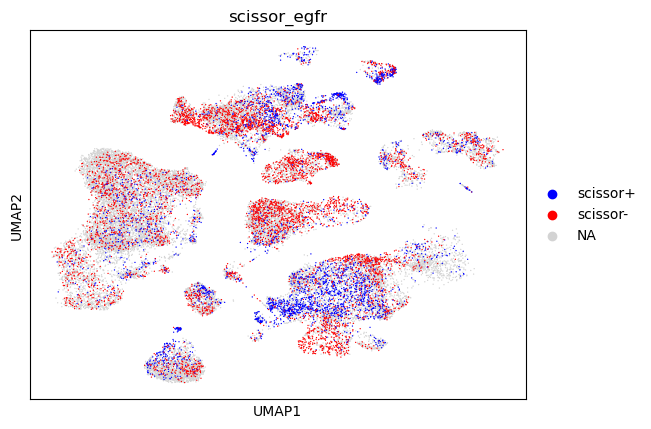

In [19]:
sc.pl.umap(adata_tumor, color="scissor_egfr", palette={"scissor+": "blue", "scissor-": "red"})

## 6. Statistical comparison